In [1]:
import os
import copy
import torch

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import torchvision.transforms as transforms

from eval import accuracy
from model import MnistCNN
from train import fit, evaluate
from torchvision.datasets import MNIST
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline

In [2]:
BATCH_SIZE = 100
NUM_CLASSES = 10
INPUT_SIZE = 28 * 28
DATASET = MNIST(root='data/', download=True, train=True, transform=transforms.ToTensor())

In [3]:
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu" 

def split_indices(n, val_pct):
    # Determine size of validation set
    n_val = int(val_pct*n)

    idxs = np.random.permutation(n)

    return idxs[n_val:], idxs[:n_val]

train_indexes, validation_indexes = split_indices(len(DATASET), 0.2)

train_sampler = SubsetRandomSampler(train_indexes)
train_loader = DataLoader(DATASET, BATCH_SIZE, sampler=train_sampler)

val_sampler = SubsetRandomSampler(validation_indexes)
val_loader = DataLoader(DATASET, BATCH_SIZE, sampler=val_sampler)

loss_fun = F.cross_entropy

def predict_image(image, model):
    xb = image.unsqueeze(0).to(dev)
    yb = model(xb)
    yb = yb.to(dev)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

In [4]:
learning_rate = 0.0001

model = MnistCNN().to(dev)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
fit(20, model, loss_fun, optimizer, train_loader, val_loader, accuracy)

Epoch 1, loss: 0.3640, accuracy: 0.8926
Epoch 2, loss: 0.2267, accuracy: 0.9326
Epoch 3, loss: 0.1825, accuracy: 0.9456
Epoch 4, loss: 0.1514, accuracy: 0.9534
Epoch 5, loss: 0.1340, accuracy: 0.9595
Epoch 6, loss: 0.1259, accuracy: 0.9613
Epoch 7, loss: 0.1124, accuracy: 0.9657
Epoch 8, loss: 0.1046, accuracy: 0.9675
Epoch 9, loss: 0.0981, accuracy: 0.9690
Epoch 10, loss: 0.0921, accuracy: 0.9703
Epoch 11, loss: 0.0881, accuracy: 0.9723
Epoch 12, loss: 0.0850, accuracy: 0.9722
Epoch 13, loss: 0.0827, accuracy: 0.9734
Epoch 14, loss: 0.0816, accuracy: 0.9744
Epoch 15, loss: 0.0761, accuracy: 0.9761
Epoch 16, loss: 0.0757, accuracy: 0.9761
Epoch 17, loss: 0.0767, accuracy: 0.9755
Epoch 18, loss: 0.0750, accuracy: 0.9763
Epoch 19, loss: 0.0728, accuracy: 0.9772
Epoch 20, loss: 0.0692, accuracy: 0.9787


In [6]:
test_dataset = MNIST(root='data/', train=False, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=1)
test_loss, total, test_acc = evaluate(model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

Loss: 0.0546, accuracy: 0.9819


In [7]:
# Helper functions to measur sparsity of a model
def measure_module_sparsity(module, weight=True, bias=False, use_mask=False):
    num_zeros = 0
    num_elements = 0
    if use_mask == True:
        for buffer_name, buffer in module.named_buffers():
            if "weight_mask" in buffer_name and weight == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
            if "bias_mask" in buffer_name and bias == True:
                num_zeros += torch.sum(buffer == 0).item()
                num_elements += buffer.nelement()
    else:
        for param_name, param in module.named_parameters():
            if "weight" in param_name and weight == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
            if "bias" in param_name and bias == True:
                num_zeros += torch.sum(param == 0).item()
                num_elements += param.nelement()
    sparsity = num_zeros / num_elements
    return num_zeros, num_elements, sparsity

def measure_global_sparsity(model, weight=True, bias=False, conv2d_use_mask=False, linear_use_mask=False):
    num_zeros = 0
    num_elements = 0
    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            module_num_zeros, module_num_elements, _ = measure_module_sparsity(module, weight=weight, bias=bias, use_mask=conv2d_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements

        elif isinstance(module, torch.nn.Linear):
            module_num_zeros, module_num_elements, _ = measure_module_sparsity(module, weight=weight, bias=bias, use_mask=linear_use_mask)
            num_zeros += module_num_zeros
            num_elements += module_num_elements
    sparsity = num_zeros / num_elements
    return num_zeros, num_elements, sparsity

In [8]:
def LRP_0(model : nn.Module, X):
    layers = [module for module in model.named_children() if not isinstance(module, torch.nn.Sequential)]
    L = len(layers)
    A = [X] + [X] * L
    # compute forward activations of NN
    for layer in range(L):
        if layers[layer][0] == 'pool1':
            pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)
            output1, indices1 = pool(A[layer])
            A[layer + 1] = output1
            continue
        if layers[layer][0] == 'pool2':
            pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False, return_indices=True)
            output2, indices2 = pool(A[layer])
            A[layer + 1] = output2
            continue
        A[layer + 1] = layers[layer][1].forward(A[layer])

    T = A[-1].cpu().detach().numpy().tolist()[0]
    index = T.index(max(T))
    T = np.abs(np.array(T)) * 0
    T[index] = 1
    T = torch.FloatTensor(T)
    R = [None] * L + [(A[-1].cpu() * T).data + 1e-6]
    # do a backward to get relevance of neurons
    # plase dont mind the if statements, I wasnt able to
    # make it more generic
    for layer in range(0, L)[::-1]:
        if layers[layer][0] == 'flatten':
            R[layer] = torch.reshape(A[layer], (32,7,7))
            continue
        if layers[layer][0] == 'pool2':
            unpool = nn.MaxUnpool2d(kernel_size=2)
            R[layer] = unpool(A[layer+1], indices2)
            continue
        if layers[layer][0] == 'pool1':
            unpool = nn.MaxUnpool2d(kernel_size=2)
            R[layer] = unpool(A[layer+1], indices1)
            continue
        if layers[layer][0] == 'relu1' or layers[layer][0] == 'relu2':
            R[layer] = A[layer + 1]
            continue
        A[layer] = A[layer].data.requires_grad_(True)
        z = newlayer(layers[layer][1]).forward(A[layer]) + 1e-9
        s = (R[layer+1].to(dev) / z).data
        (z * s).sum().backward()
        c = A[layer].grad
        R[layer] = (A[layer] * c).cpu().data 
    return R[0], R, L
        
# Create copy of a layer
def newlayer(layer : nn.Module) -> nn.Module:
    layer = copy.deepcopy(layer)
    layer.weight = torch.nn.Parameter(layer.weight)
    layer.bias = torch.nn.Parameter(layer.bias)
    return layer

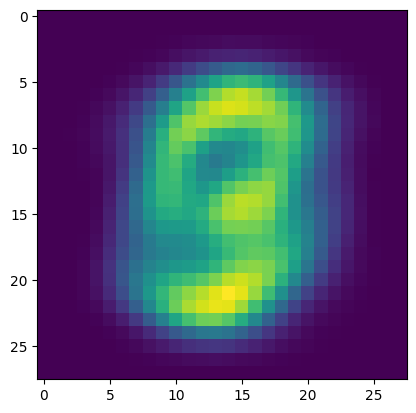

In [9]:
# Iterate throught the test data and collect relevance of neurons
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
loader = DataLoader(DATASET, 1, sampler=train_sampler)
image, label = next(iter(loader))
model(image.to(dev))
lrp_0, lrp, layers_len = LRP_0(model, image.to(dev))

for image, label in test_loader:
    out1, out2, _ = LRP_0(model, image.to(dev))
    lrp_0 += out1
    lrp += out2

img = lrp_0.squeeze(0).permute(1,2,0).numpy()
plt.imshow(img)

In [10]:
# Based on the relevance, prune the weights in the convs and linear layers
# This is not very generic and I would like to spend some time after the exams
# to make it as generic as possible
# Please dont mind the l1_unstructered pruning, it just creates named buffer 
# for the weights mask, which gets then replaced by the mask computed from the LRP
def prune_by_LRP(model : nn.Module, lrp, threshold_conv=10, threshold_fc_lower=-1e-5, threshold_fc_higher=1e-5):
    model_copy = copy.deepcopy(model)
    np_arr = lrp[1].cpu().data.numpy()
    indexes = []
    for x in range(np_arr.shape[1]):
        relevance_sum = np.sum(np_arr[0][x])
        if relevance_sum < threshold_conv:
            indexes.append(x)
    a = np.ones((model_copy.conv1.out_channels, model_copy.conv1.in_channels, model_copy.conv1.weight[0].shape[1], model_copy.conv1.weight[0].shape[2]))
    a[indexes] = np.zeros((model_copy.conv1.in_channels, model_copy.conv1.weight[0].shape[1], model_copy.conv1.weight[0].shape[2]))
    prune.l1_unstructured(model_copy.conv1, name='weight', amount=0.0)
    with torch.no_grad():
        prune.custom_from_mask(model_copy.conv1, name='weight', mask=torch.Tensor(a).to(dev))

    np_arr = lrp[4].cpu().data.numpy()
    indexes = []
    for x in range(np_arr.shape[1]):
        relevance_sum = np.sum(np_arr[0][x])
        if relevance_sum < threshold_conv:
            indexes.append(x)
    a = np.ones((model_copy.conv2.out_channels, model_copy.conv2.in_channels, model_copy.conv2.weight[0].shape[1], model_copy.conv2.weight[0].shape[2]))
    a[indexes] = np.zeros((model_copy.conv2.in_channels, model_copy.conv2.weight[0].shape[1], model_copy.conv2.weight[0].shape[2]))
    prune.l1_unstructured(model_copy.conv2, name='weight', amount=0.0)
    with torch.no_grad():
        prune.custom_from_mask(model_copy.conv2, name='weight', mask=torch.Tensor(a).to(dev))

    np_arr = lrp[-2].cpu().data.numpy()
    indexes = []
    for x in range(np_arr.shape[1]):
        relevance_sum = np.sum(np_arr[0][x])
        if relevance_sum > threshold_fc_lower and relevance_sum < threshold_fc_higher:
            indexes.append(x)
    prune.l1_unstructured(model_copy.out, name='weight', amount=0.0)
    a = np.ones((list(model_copy.out.named_buffers())[0][1].shape[1]))
    a[indexes] = 0
    a = np.array([a] * 10)
    with torch.no_grad():
        prune.custom_from_mask(model_copy.out, name='weight', mask=torch.Tensor(a).to(dev))
    return model_copy

In [17]:
test_loader = DataLoader(test_dataset, batch_size=16)
accuracys = []
sparsitys = []
finetuned_accuracys = []
lower_threshold = np.arange(-0.0001, -0.11, -0.0001)
higher_threshold = np.arange(0.0001, 0.11, 0.0001)
for x in range(1, 3):
    # for i, j in zip(lower_threshold, higher_threshold):
    pruned_model = prune_by_LRP(model, lrp, x)
    sparsity = measure_global_sparsity(pruned_model, True, False, True, True)[-1]
    test_loss, total, test_acc = evaluate(pruned_model, loss_fun, test_loader, metric=accuracy)
    accuracys.append(test_acc)
    sparsitys.append(sparsity)
    optimizer = torch.optim.Adam(pruned_model.parameters(), lr=learning_rate)
    fit(5, pruned_model, loss_fun, optimizer, train_loader, val_loader, accuracy)
    test_loss, total, test_acc = evaluate(pruned_model, loss_fun, test_loader, metric=accuracy)
    finetuned_accuracys.append(test_acc)

Epoch 1, loss: 0.0962, accuracy: 0.9687
Epoch 2, loss: 0.0867, accuracy: 0.9729
Epoch 3, loss: 0.0819, accuracy: 0.9746
Epoch 4, loss: 0.0848, accuracy: 0.9731
Epoch 5, loss: 0.0774, accuracy: 0.9754
Epoch 1, loss: 0.1016, accuracy: 0.9669
Epoch 2, loss: 0.0930, accuracy: 0.9700
Epoch 3, loss: 0.0859, accuracy: 0.9723
Epoch 4, loss: 0.0874, accuracy: 0.9728
Epoch 5, loss: 0.0783, accuracy: 0.9739


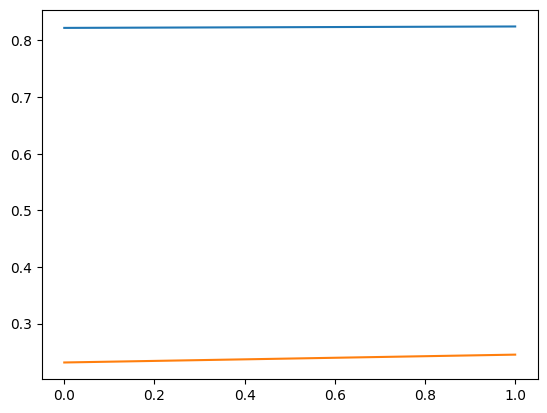

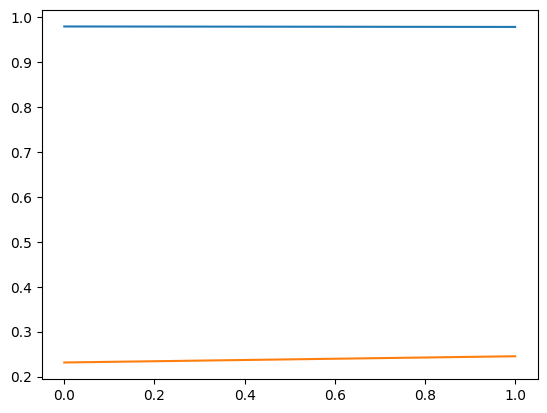

In [18]:
plt.plot(accuracys)
plt.plot(sparsitys)
plt.figure()
plt.plot(finetuned_accuracys)
plt.plot(sparsitys)

In [36]:
pruned_model = prune_by_LRP(model, lrp, 5)
test_loader = DataLoader(test_dataset, batch_size=16)
print(f"Sparsity of a pruned model: {measure_global_sparsity(pruned_model, True, False, True, True)[-1]:.4f}")
test_loss, total, test_acc = evaluate(pruned_model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

# Perform a finetuning of a pruned network
optimizer = torch.optim.Adam(pruned_model.parameters(), lr=learning_rate)
fit(2, pruned_model, loss_fun, optimizer, train_loader, val_loader, accuracy)

test_loss, total, test_acc = evaluate(pruned_model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

Sparsity of a pruned model: 0.1524
Loss: 0.1682, accuracy: 0.9457
Epoch 1, loss: 0.0786, accuracy: 0.9752
Epoch 2, loss: 0.0788, accuracy: 0.9763
Loss: 0.0675, accuracy: 0.9789


In [37]:
pruned_model = prune_by_LRP(model, lrp, 5, threshold_fc_lower=-1e-1, threshold_fc_higher=1e-1)
print(f"Sparsity of a pruned model: {measure_global_sparsity(pruned_model, True, False, True, True)[-1]:.4f}")

test_loss, total, test_acc = evaluate(pruned_model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

# Perform a finetuning of a pruned network
optimizer = torch.optim.Adam(pruned_model.parameters(), lr=learning_rate)
fit(2, pruned_model, loss_fun, optimizer, train_loader, val_loader, accuracy)

test_loss, total, test_acc = evaluate(pruned_model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

Sparsity of a pruned model: 0.3722
Loss: 2.2596, accuracy: 0.5320
Epoch 1, loss: 0.1313, accuracy: 0.9603
Epoch 2, loss: 0.1107, accuracy: 0.9673
Loss: 0.0974, accuracy: 0.9706


In [38]:
pruned_model = prune_by_LRP(model, lrp, 10)
print(f"Sparsity of a pruned model: {measure_global_sparsity(pruned_model, True, False, True, True)[-1]:.4f}")

test_loss, total, test_acc = evaluate(pruned_model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

# Perform a finetuning of a pruned network
optimizer = torch.optim.Adam(pruned_model.parameters(), lr=learning_rate)
fit(2, pruned_model, loss_fun, optimizer, train_loader, val_loader, accuracy)

test_loss, total, test_acc = evaluate(pruned_model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

Sparsity of a pruned model: 0.2355
Loss: 0.2423, accuracy: 0.9184
Epoch 1, loss: 0.0899, accuracy: 0.9721
Epoch 2, loss: 0.0812, accuracy: 0.9757
Loss: 0.0742, accuracy: 0.9778


In [39]:
pruned_model = prune_by_LRP(model, lrp, 10, threshold_fc_lower=-1e-1, threshold_fc_higher=1e-1)
print(f"Sparsity of a pruned model: {measure_global_sparsity(pruned_model, True, False, True, True)[-1]:.4f}")

test_loss, total, test_acc = evaluate(pruned_model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

# Perform a finetuning of a pruned network
optimizer = torch.optim.Adam(pruned_model.parameters(), lr=learning_rate)
fit(2, pruned_model, loss_fun, optimizer, train_loader, val_loader, accuracy)

test_loss, total, test_acc = evaluate(pruned_model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

Sparsity of a pruned model: 0.4553
Loss: 2.3498, accuracy: 0.4673
Epoch 1, loss: 0.1563, accuracy: 0.9543
Epoch 2, loss: 0.1227, accuracy: 0.9637
Loss: 0.1136, accuracy: 0.9672


In [40]:
pruned_model = prune_by_LRP(model, lrp, 15)
print(f"Sparsity of a pruned model: {measure_global_sparsity(pruned_model, True, False, True, True)[-1]:.4f}")

test_loss, total, test_acc = evaluate(pruned_model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

# Perform a finetuning of a pruned network
optimizer = torch.optim.Adam(pruned_model.parameters(), lr=learning_rate)
fit(2, pruned_model, loss_fun, optimizer, train_loader, val_loader, accuracy)

test_loss, total, test_acc = evaluate(pruned_model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

Sparsity of a pruned model: 0.2909
Loss: 0.5474, accuracy: 0.8164
Epoch 1, loss: 0.1097, accuracy: 0.9670
Epoch 2, loss: 0.0998, accuracy: 0.9701
Loss: 0.0905, accuracy: 0.9726


In [41]:
pruned_model = prune_by_LRP(model, lrp, 15, threshold_fc_lower=-1e-1, threshold_fc_higher=1e-1)
print(f"Sparsity of a pruned model: {measure_global_sparsity(pruned_model, True, False, True, True)[-1]:.4f}")

test_loss, total, test_acc = evaluate(pruned_model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

# Perform a finetuning of a pruned network
optimizer = torch.optim.Adam(pruned_model.parameters(), lr=learning_rate)
fit(2, pruned_model, loss_fun, optimizer, train_loader, val_loader, accuracy)

test_loss, total, test_acc = evaluate(pruned_model, loss_fun, test_loader, metric=accuracy)
print(f"Loss: {test_loss:.4f}, accuracy: {test_acc:.4f}")

Sparsity of a pruned model: 0.5107
Loss: 2.5187, accuracy: 0.4765
Epoch 1, loss: 0.1750, accuracy: 0.9487
Epoch 2, loss: 0.1394, accuracy: 0.9603
Loss: 0.1287, accuracy: 0.9640
